<a href="https://colab.research.google.com/github/cardstud/DS-Unit-2-Applied-Modeling/blob/master/BW2_project_3_9_2020_lastcopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import dataset and needed libraries/packages

In [0]:
# Install needed packages
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install plotly==4.*
!pip install eli5
!pip install pdpbox
!pip install shap

# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [217]:
from google.colab import files
uploaded = files.upload()

Saving framingham.csv to framingham (2).csv


In [0]:
hd = pd.read_csv('framingham.csv', header=0)

### Explore Dataset and Target

In [219]:
hd.head()

male  age  education  currentSmoker  ...    BMI  heartRate  glucose  TenYearCHD
0     1   39        4.0              0  ...  26.97       80.0     77.0           0
1     0   46        2.0              0  ...  28.73       95.0     76.0           0
2     1   48        1.0              1  ...  25.34       75.0     70.0           0
3     0   61        3.0              1  ...  28.58       65.0    103.0           1
4     0   46        3.0              1  ...  23.10       85.0     85.0           0

[5 rows x 16 columns]

In [220]:
hd.describe()

male          age  ...      glucose   TenYearCHD
count  4240.000000  4240.000000  ...  3852.000000  4240.000000
mean      0.429245    49.580189  ...    81.963655     0.151887
std       0.495027     8.572942  ...    23.954335     0.358953
min       0.000000    32.000000  ...    40.000000     0.000000
25%       0.000000    42.000000  ...    71.000000     0.000000
50%       0.000000    49.000000  ...    78.000000     0.000000
75%       1.000000    56.000000  ...    87.000000     0.000000
max       1.000000    70.000000  ...   394.000000     1.000000

[8 rows x 16 columns]

In [221]:
hd['TenYearCHD'].describe()

count    4240.000000
mean        0.151887
std         0.358953
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TenYearCHD, dtype: float64

In [222]:
# Check to see how many classes
hd['TenYearCHD'].nunique()

2

In [223]:
# Are the classes balanced; no
hd['TenYearCHD'].value_counts(normalize=True)

0    0.848113
1    0.151887
Name: TenYearCHD, dtype: float64

In [224]:
# This is the majority class 
hd['TenYearCHD'].value_counts(normalize=True).max()

0.8481132075471698

In [225]:
# Profile report
import pandas_profiling
hd.profile_report()

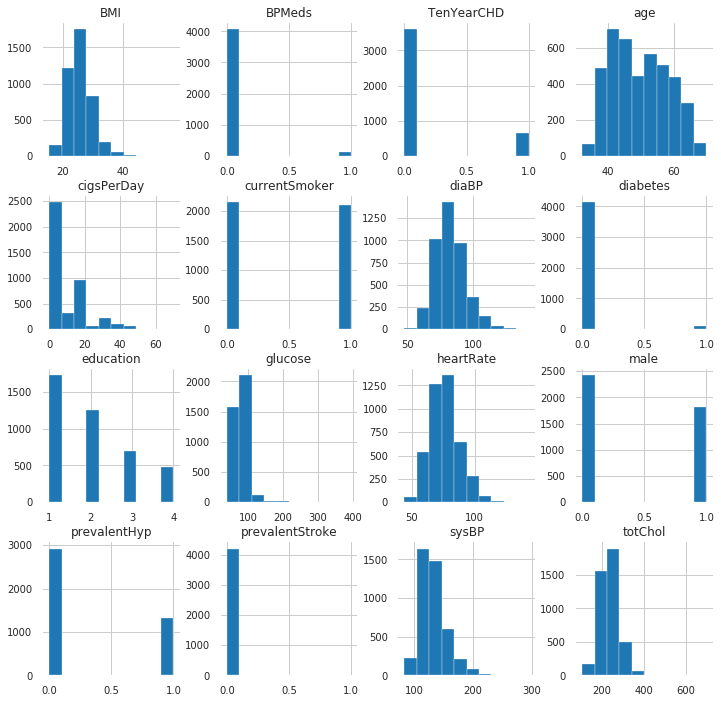

In [226]:
# Check distribution of each features's observations with Histogram
fig=plt.figure(figsize=(12,12))
ax=fig.gca()
hd.hist(ax=ax);

#### Feature Engineering and Selection

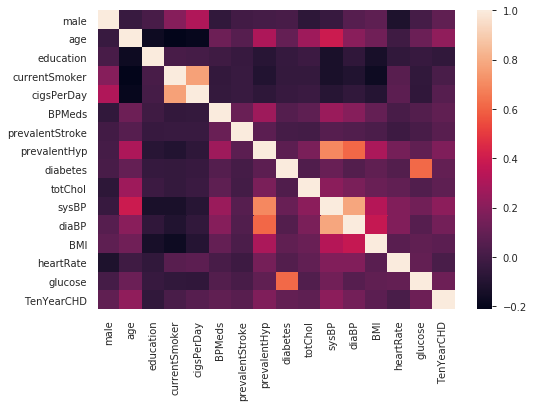

In [227]:
# Heat map to check correlation of variables to each other and dependent
#   variable, TenYearCHD
hd_corr = hd.corr()
sns.heatmap(hd_corr);

#### Based on the above distributions and heatmap, removing those features with very low correlation with output variable 
- currentSmoker
- education
- diaBP
- prevalentStroke
- diabetes
- BPMeds

In [0]:
hd = hd.drop(['currentSmoker', 'education', 'diaBP', 'prevalentStroke', 'diabetes', 'BPMeds'], axis=1)

In [174]:
hd

male  age  cigsPerDay  ...  heartRate  glucose  TenYearCHD
0        1   39         0.0  ...       80.0     77.0           0
1        0   46         0.0  ...       95.0     76.0           0
2        1   48        20.0  ...       75.0     70.0           0
3        0   61        30.0  ...       65.0    103.0           1
4        0   46        23.0  ...       85.0     85.0           0
...    ...  ...         ...  ...        ...      ...         ...
4235     0   48        20.0  ...       84.0     86.0           0
4236     0   44        15.0  ...       86.0      NaN           0
4237     0   52         0.0  ...       80.0    107.0           0
4238     1   40         0.0  ...       67.0     72.0           0
4239     0   39        30.0  ...       85.0     80.0           0

[4240 rows x 10 columns]

### Clean the Dataset

In [228]:
# check for null values (missing values)
hd.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [229]:
# Dropping all rows with missing data
hd = hd.dropna()
hd.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

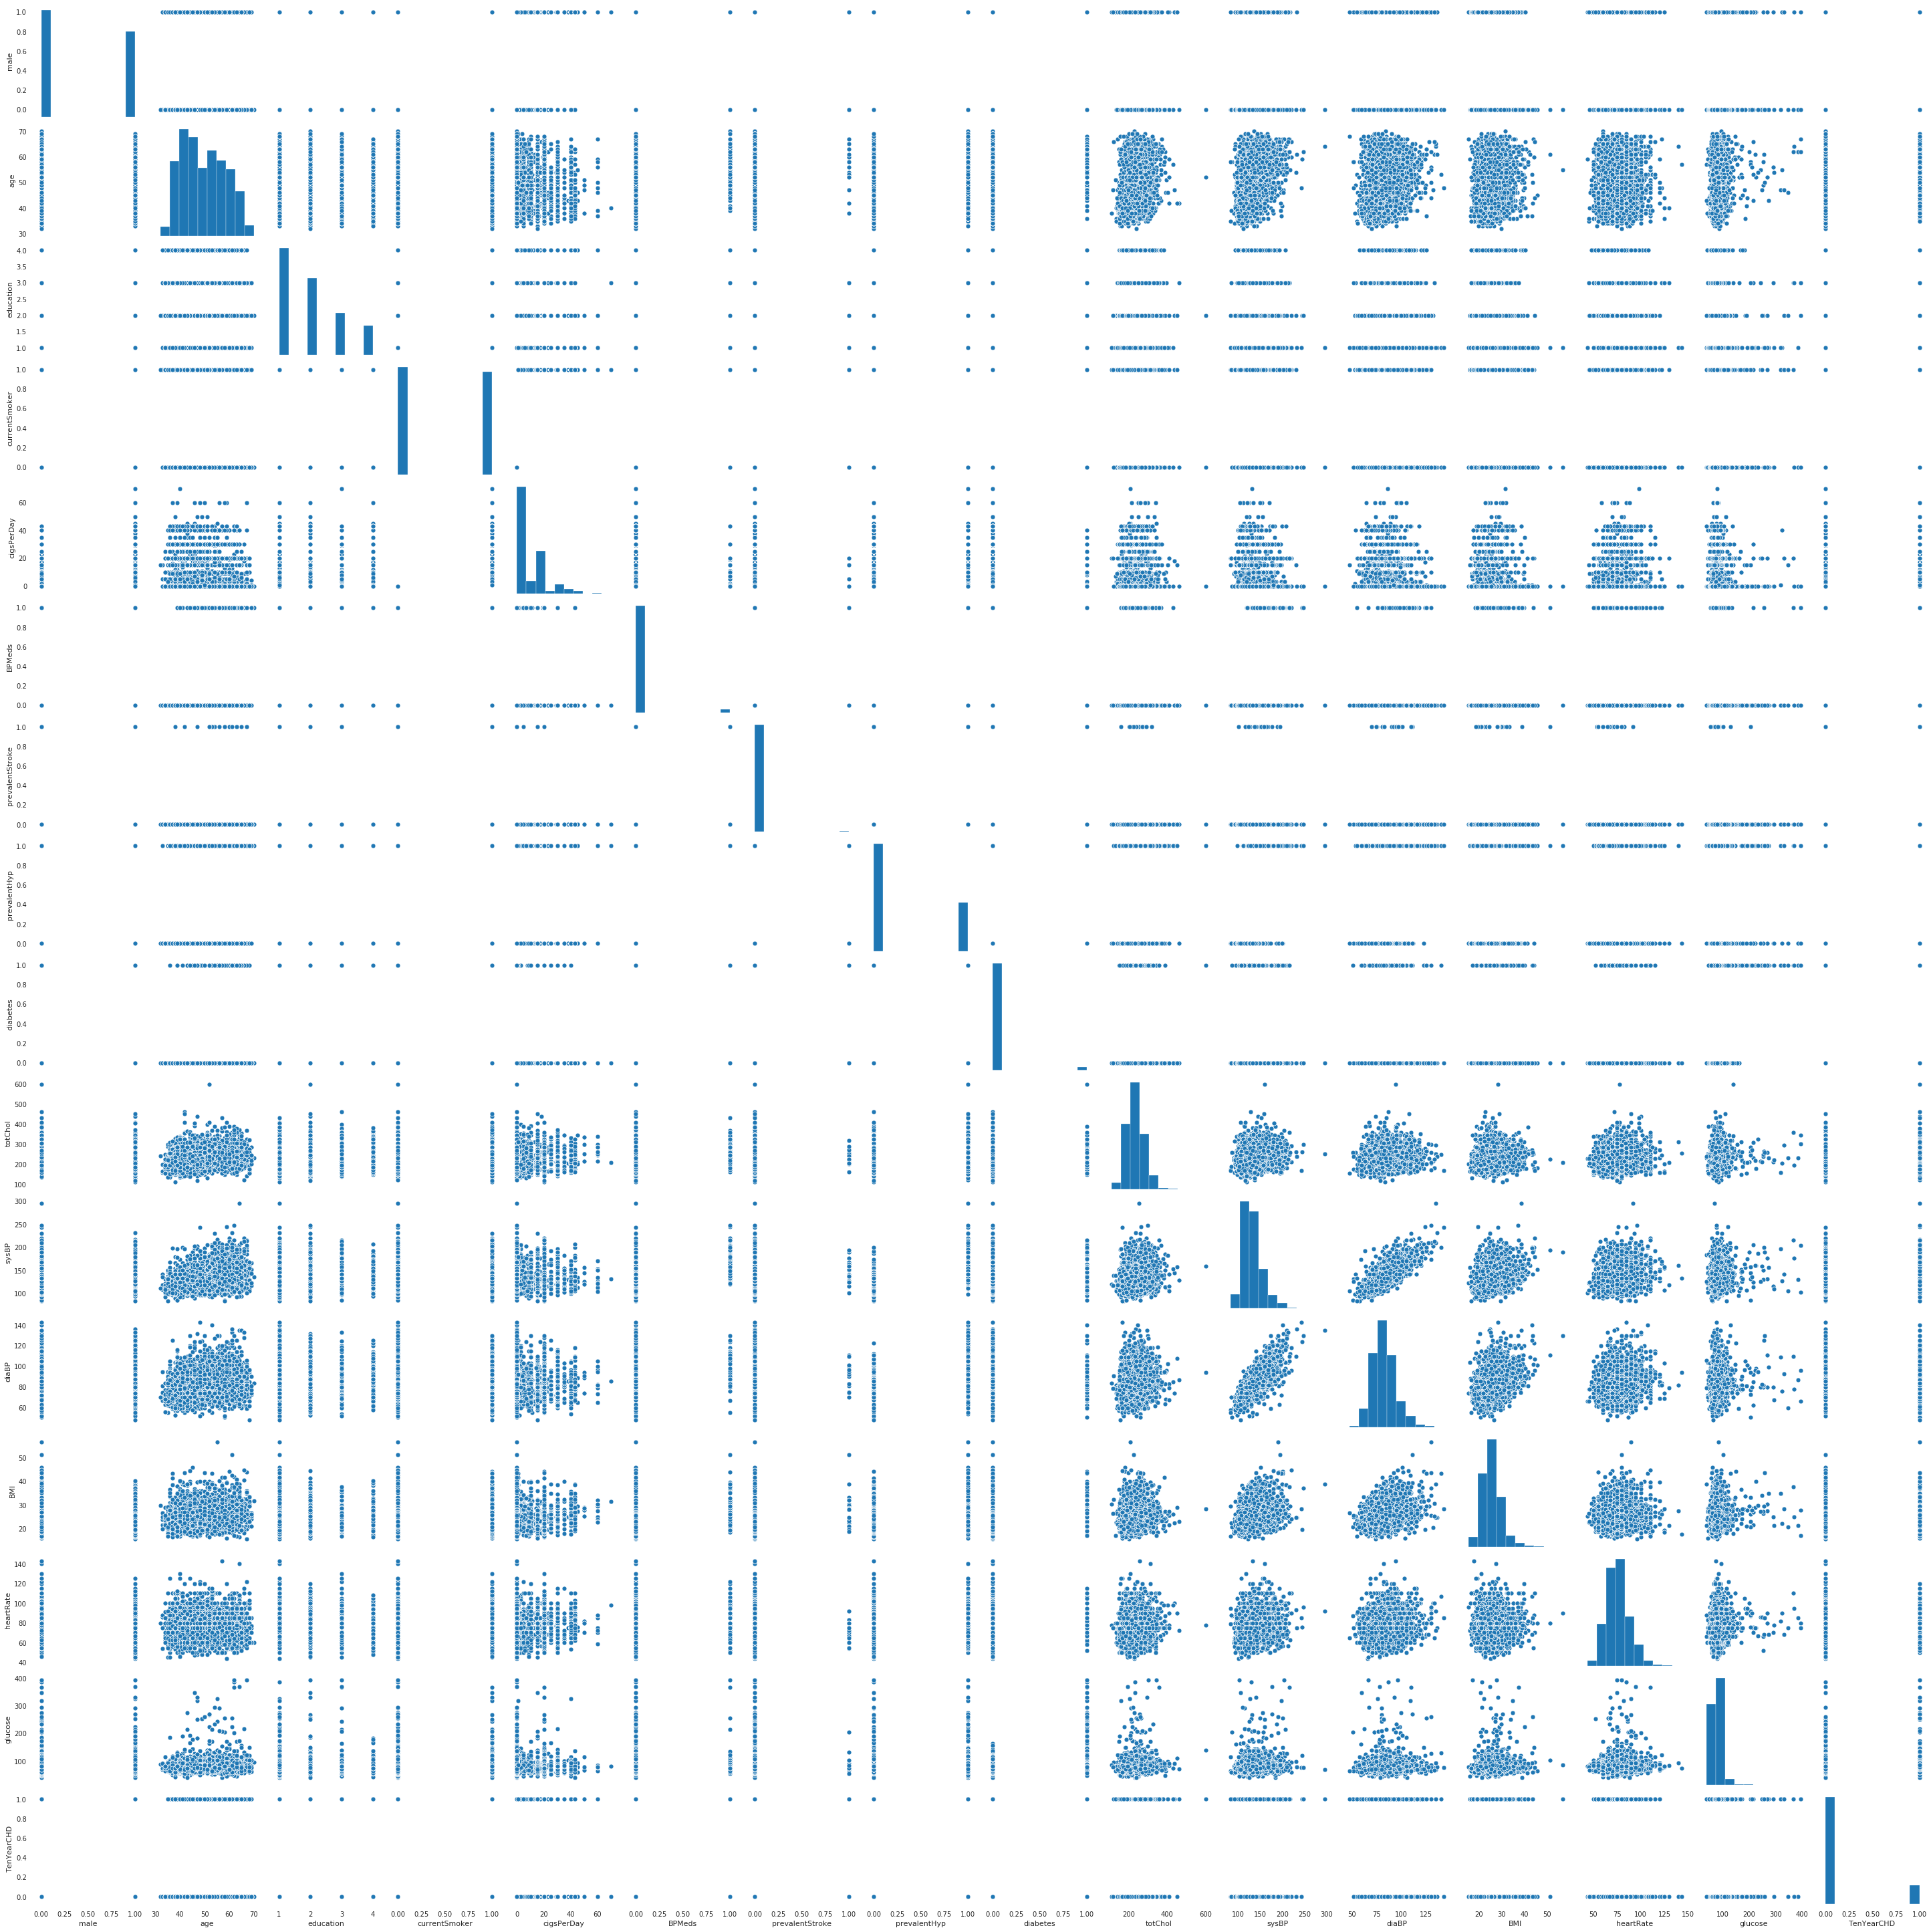

In [230]:
# Checking for outliers
hd.describe()
sns.pairplot(hd)

male  age  education  ...  heartRate  glucose  TenYearCHD
1111     0   52        2.0  ...       78.0    140.0           1

[1 rows x 16 columns]

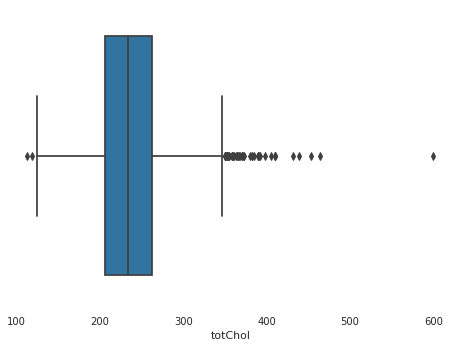

In [231]:
# Drop outliers from totChol attribute
sns.boxplot(hd.totChol)
outliers = hd[(hd['totChol'] > 500)] 
outliers

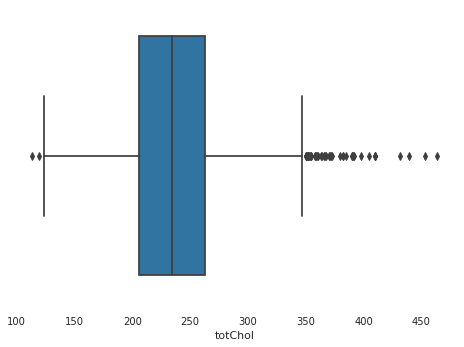

In [232]:
# Dropping outliers in totalChol
hd = hd.drop(hd[hd.totChol > 599].index)
sns.boxplot(hd.totChol)

#### Feature Importances

In [233]:
# Identify the features with the most importance for the outcome variable Heart Disease

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# separate independent & dependent variables
X = hd.iloc[:,0:9]  #independent columns
y = hd.iloc[:,-1]    #target column 

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(X,y)
hdscores = pd.DataFrame(fit.scores_)
hdcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([hdcolumns,hdscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(11,'Score'))  #print 10 best features

             Specs       Score
1              age  296.188307
4       cigsPerDay  158.937232
7     prevalentHyp   82.146445
8         diabetes   28.875545
5           BPMeds   28.299156
0             male   17.345119
6  prevalentStroke    8.535754
2        education    7.748139
3    currentSmoker    0.733356


In [234]:
featureScores = featureScores.sort_values(by='Score', ascending=False)
featureScores

Specs       Score
1              age  296.188307
4       cigsPerDay  158.937232
7     prevalentHyp   82.146445
8         diabetes   28.875545
5           BPMeds   28.299156
0             male   17.345119
6  prevalentStroke    8.535754
2        education    7.748139
3    currentSmoker    0.733356

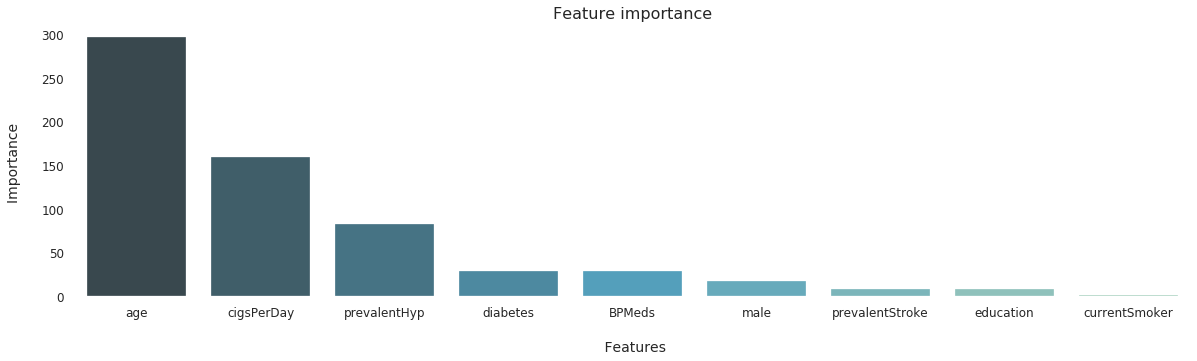

In [235]:
# visualizing feature selection
plt.figure(figsize=(20,5))
sns.barplot(x='Specs', y='Score', data=featureScores, palette = "GnBu_d")
plt.box(False)
plt.title('Feature importance', fontsize=16)
plt.xlabel('\n Features', fontsize=14)
plt.ylabel('Importance \n', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [236]:
hd.head()

male  age  education  currentSmoker  ...    BMI  heartRate  glucose  TenYearCHD
0     1   39        4.0              0  ...  26.97       80.0     77.0           0
1     0   46        2.0              0  ...  28.73       95.0     76.0           0
2     1   48        1.0              1  ...  25.34       75.0     70.0           0
3     0   61        3.0              1  ...  28.58       65.0    103.0           1
4     0   46        3.0              1  ...  23.10       85.0     85.0           0

[5 rows x 16 columns]

In [237]:
# New dataframe with just the features we want
hd = hd[['sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'prevalentHyp', 'male', 'BMI', 'heartRate', 'TenYearCHD']]
hd

sysBP  glucose  age  totChol  ...  male    BMI  heartRate  TenYearCHD
0     106.0     77.0   39    195.0  ...     1  26.97       80.0           0
1     121.0     76.0   46    250.0  ...     0  28.73       95.0           0
2     127.5     70.0   48    245.0  ...     1  25.34       75.0           0
3     150.0    103.0   61    225.0  ...     0  28.58       65.0           1
4     130.0     85.0   46    285.0  ...     0  23.10       85.0           0
...     ...      ...  ...      ...  ...   ...    ...        ...         ...
4233  179.0     86.0   50    313.0  ...     1  25.97       66.0           1
4234  126.5     68.0   51    207.0  ...     1  19.71       65.0           0
4237  133.5    107.0   52    269.0  ...     0  21.47       80.0           0
4238  141.0     72.0   40    185.0  ...     1  25.60       67.0           0
4239  133.0     80.0   39    196.0  ...     0  20.91       85.0           0

[3657 rows x 10 columns]

### Split datasets into Train, Validation and Test sets

In [238]:
from sklearn.model_selection import train_test_split
# Split into Train and Test sets
train, test = train_test_split(hd, train_size=.80, test_size=0.20,
                               stratify=hd['TenYearCHD'], random_state=42)
train.shape,  test.shape

((2925, 10), (732, 10))

In [239]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['TenYearCHD'], random_state=42)

train.shape, val.shape, test.shape

((2340, 10), (585, 10), (732, 10))

### Begin with baselines for classification

In [240]:
# Determine majority class
# This is the accuracy score of the baseline as well
target = 'TenYearCHD'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.847863
1    0.152137
Name: TenYearCHD, dtype: float64

In [241]:
# Training accuracy of majority class baseline = frequency of majority class
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)

accuracy_score(y_train, y_pred)

0.8478632478632478

 Since this dataset is very unbalanced, I will not use accuracy as a metric. Instead, precision/recall/f1 will be used

### Logistic Regression - Binary Classification
- Separate X&Y/encode/impute/scale/fit model

In [256]:
hd.head()

sysBP  glucose  age  totChol  ...  male    BMI  heartRate  TenYearCHD
0  106.0     77.0   39    195.0  ...     1  26.97       80.0           0
1  121.0     76.0   46    250.0  ...     0  28.73       95.0           0
2  127.5     70.0   48    245.0  ...     1  25.34       75.0           0
3  150.0    103.0   61    225.0  ...     0  28.58       65.0           1
4  130.0     85.0   46    285.0  ...     0  23.10       85.0           0

[5 rows x 10 columns]

In [268]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


target = ['TenYearCHD']
features = ['sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'prevalentHyp',
            'male','BMI', 'heartRate']

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(random_state=42, class_weight="balanced"),
)


pipeline.fit(X_train, y_train)

print ('Logistic Regression Model Test Accuracy', pipeline.score(X_test, y_test))
print(classification_report(y_test, pipeline.predict(X_test)))

Logistic Regression Model Test Accuracy 0.6830601092896175
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       621
           1       0.29      0.73      0.41       111

    accuracy                           0.68       732
   macro avg       0.61      0.70      0.60       732
weighted avg       0.84      0.68      0.73       732



In [0]:
from sklearn.metrics import roc_auc_score

In [270]:
y_pred =  pipeline.predict(X_val)
print(roc_auc_score(y_val, y_pred))

0.6844305001812251


In [271]:
# Test Case
# sysBP = 120, glucose = 75, age = 45, totChol = 250, cigsPerDay = 5, 
#               prevalantHyp = 1, male = 0, BMI = 24, heartRate = 115)
test_case = [[120, 75, 45, 250, 5, 1, 0, 24, 115]]
pipeline.predict(test_case)

array([0])

#### Threshold Example

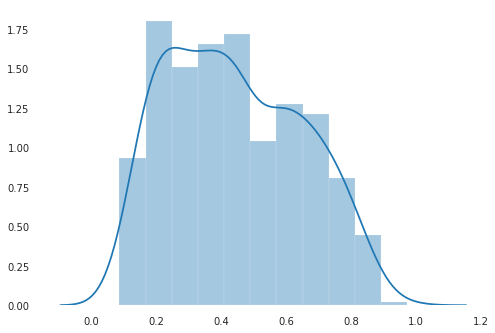

In [272]:
# Look at the distribution of positive class prediction probabilities
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba);

In [278]:
from ipywidgets import interact, fixed

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))

# As we incease the threshold, the precision increases. 
interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [279]:
y_val['TenYearCHD'].value_counts()

0    496
1     89
Name: TenYearCHD, dtype: int64

In [280]:
patients = 100
print(f'Baseline: {int(patients * 0.15)} high risk would be identified in {patients} selected for additional testing')

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
results = pd.DataFrame({'y_val': y_val['TenYearCHD'], 'y_pred_proba': y_pred_proba})
top100 = results.sort_values(by='y_pred_proba', ascending=False)[:100]
relevant_recommendations = top100['y_val'].sum()
print(f'With model: Predict {relevant_recommendations} high risk would be identified in {patients} selected for additional testing')

Baseline: 15 high risk would be identified in 100 selected for additional testing
With model: Predict 32 high risk would be identified in 100 selected for additional testing


By using the outputs of the Logistic Regression model, the hospital would be able to more effectively select patients that need additional testing. If each test cost $800, then using this model would better allocate 16 * 800 = $12,800.

### Decision Tree

In [263]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = ['TenYearCHD']
features = ['sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'prevalentHyp',
            'male','BMI', 'heartRate']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=3, class_weight="balanced")
)

pipeline.fit(X_train, y_train)

print(classification_report(y_test, pipeline.predict(X_test)))


              precision    recall  f1-score   support

           0       0.93      0.65      0.76       621
           1       0.27      0.72      0.39       111

    accuracy                           0.66       732
   macro avg       0.60      0.68      0.58       732
weighted avg       0.83      0.66      0.71       732



In [0]:
# Use scikit-learn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
y_pred = pipeline.predict(X_val) 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [248]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

False Positive Rate  True Positive Rate  Threshold
0             0.000000            0.000000          2
1             0.350806            0.606742          1
2             1.000000            1.000000          0

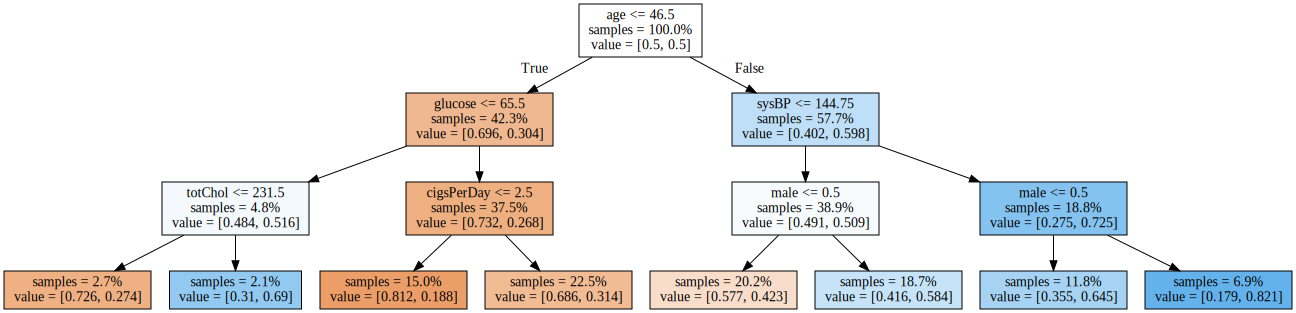

In [249]:
# Visualize decision tree
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(model, 
    out_file=None, 
    max_depth = 3,
    feature_names=X_train.columns, 
    filled=True, 
    impurity=False, 
    proportion=True)

graphviz.Source(dot_data)

### XGBOOST

In [250]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, objective='binary:logistic',
                  random_state=42, n_jobs=-1, sample_weight='balanced')
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)

print(classification_report(y_test, pipeline.predict(X_test)))

#print('Validation Accuracy:', pipeline.score(X_val, y_val))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       644
           1       0.56      0.16      0.25       116

    accuracy                           0.85       760
   macro avg       0.71      0.57      0.59       760
weighted avg       0.82      0.85      0.82       760



#### Model Interpretation

In [251]:
example = X_val.iloc[[2]]   # taking first entry in our validation set
example

sysBP  glucose  age  totChol  ...  prevalentHyp  male    BMI  heartRate
4071  140.0     74.0   52    296.0  ...             1     0  26.81       88.0

[1 rows x 9 columns]

In [252]:
hd['BMI'].describe()

count    3657.000000
mean       25.782122
std         4.065948
min        15.540000
25%        23.080000
50%        25.380000
75%        28.030000
max        56.800000
Name: BMI, dtype: float64

In [254]:
pred = model.predict(example)[0]
print(f'Predicted TenYearCHD: {pred:.2f}%')

Predicted TenYearCHD: 0.00%


In [255]:
import numpy as np

def vary_bmi(model, example):
    print('Vary BMI, hold other features constant', '\n')
    example = example.copy()
    preds = []
    for bmi in range(15, 35, 1):
        example['BMI'] = bmi
        pred = model.predict(example)[0]
        print(f'Predicted Ten Year CHD: {pred:.3f}%')
        print(example.to_string(), '\n')
        preds.append(pred)
    print('Difference between predictions')
    print(np.diff(preds))
        
vary_bmi(pipeline, example)

Vary BMI, hold other features constant 

Predicted Ten Year CHD: 0.000%
      sysBP  glucose  age  totChol  cigsPerDay  prevalentHyp  male  BMI  heartRate
4071  140.0     74.0   52    296.0         0.0             1     0   15       88.0 

Predicted Ten Year CHD: 0.000%
      sysBP  glucose  age  totChol  cigsPerDay  prevalentHyp  male  BMI  heartRate
4071  140.0     74.0   52    296.0         0.0             1     0   16       88.0 

Predicted Ten Year CHD: 0.000%
      sysBP  glucose  age  totChol  cigsPerDay  prevalentHyp  male  BMI  heartRate
4071  140.0     74.0   52    296.0         0.0             1     0   17       88.0 

Predicted Ten Year CHD: 0.000%
      sysBP  glucose  age  totChol  cigsPerDay  prevalentHyp  male  BMI  heartRate
4071  140.0     74.0   52    296.0         0.0             1     0   18       88.0 

Predicted Ten Year CHD: 0.000%
      sysBP  glucose  age  totChol  cigsPerDay  prevalentHyp  male  BMI  heartRate
4071  140.0     74.0   52    296.0         0.0   